# Set Module Path

In [1]:
import sys
sys.path.insert(0,"/work/pip")
import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

# Load Packages

In [25]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import numpy as np
import cv2
import pdb
import matplotlib.pyplot as plt

# Select Model

In [62]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 3
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet121(pretrained=True)
    finalconv_name = 'features'

In [63]:
for param in net.parameters():
    param.requires_grad = False
for param in net.classifier.parameters():
    param.requires_grad = True

net.train()
for param in net.parameters():
    print(param.requires_grad)

# Register Forward Hook

In [7]:
#change classifier layer of net
net.classifier = nn.Linear(in_features=1024, out_features=41, bias=True)

net.eval()

# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# CAM Function

In [9]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

# Run Test Image

## ImageNet Test

In [ ]:
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

In [ ]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

## CheXpert Test

In [10]:
from Dataset import *
test_loader = DataLoader(CheXpertDataset(csv_file="./data/CheXpert-v1.0-small/valid.csv", 
                                         image_root_dir="./data/", 
                                         transform=validation_transform), 
                         batch_size=1, shuffle=True)

for batch_idx, data in enumerate(test_loader):
    if batch_idx == 1:
        break
    img_tensor = data['image']
    data.pop('image')
    img_labels = data

img_variable = Variable(img_tensor)
logit = net(img_variable)

In [12]:
import itertools
labels = list(itertools.product([label[0] for label in img_labels.items()], [0, 1, 2]))
labels.pop(2)

classes = {num:label for (label, num) in zip(labels, np.arange(41))}

In [13]:
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

0.050 -> ('Support Devices', 1)
0.047 -> ('Pleural Other', 2)
0.038 -> ('Pneumonia', 2)
0.034 -> ('Pleural Effusion', 1)
0.033 -> ('Pneumothorax', 1)


In [14]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

In [53]:
# render the CAM and output
#print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img_untransformed = inv_normalize(img_tensor.squeeze(0))
img = img_untransformed.numpy().transpose(1,2,0)
img = (img * 255).astype(int)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.7
#cv2.imwrite('CAM.jpg', result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


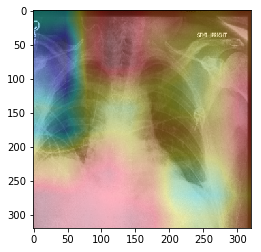

In [54]:
plt.imshow(result.astype(int))

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

imshow(img_tensor.squeeze(0))

In [ ]:
img_ex = io.imread('/work/CheXpert/data/CheXpert-v1.0-small/train/patient10435/study1/view1_frontal.jpg', as_gray=True) 
#Image.open('/work/CheXpert/data/CheXpert-v1.0-small/train/patient10435/study1/view1_frontal.jpg')

In [ ]:
plt.imshow(img_ex)
img_ex = np.repeat(img_ex[None,...], 3, axis=0)
img_transformed = validation_transform(img_ex)

In [ ]:
plt.imshow(img_transformed.numpy().transpose(1,2,0))

In [ ]:
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [18]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([364,364]),
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#img_normalized = normalize(img_ex.transpose(1,2,0))
#img_back = inv_normalize(img_normalized)
#plt.imshow(img_back.numpy().transpose(1,2,0))

In [ ]:
img_normalized.shape

In [ ]:
img_ex

In [ ]:
img_transformed

In [ ]:
np.repeat(img_ex[None,...], 3, axis=0).shape